21.03.30 자연어 처리 RNN을 이용한 창작(작곡)

# RNN을 이용한 창작(작곡)

## 코딩준비

In [1]:
import numpy as np
import music21
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

## 데이터 준비하기

### 시퀸스 데이터 정의

In [2]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

print("length of seq: {0}".format(len(seq)))

length of seq: 54


In [3]:
print(seq)

['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


In [4]:
note_seq = "".join(seq)
print(note_seq)
m = music21.converter.parse("2/4 " + note_seq, format='tinyNotation')
m.show("midi")

g8e8e4f8d8d4c8d8e8f8g8g8g4g8e8e8e8f8d8d4c8e8g8g8e8e8e4d8d8d8d8d8e8f4e8e8e8e8e8f8g4g8e8e4f8d8d4c8e8g8g8e8e8e4


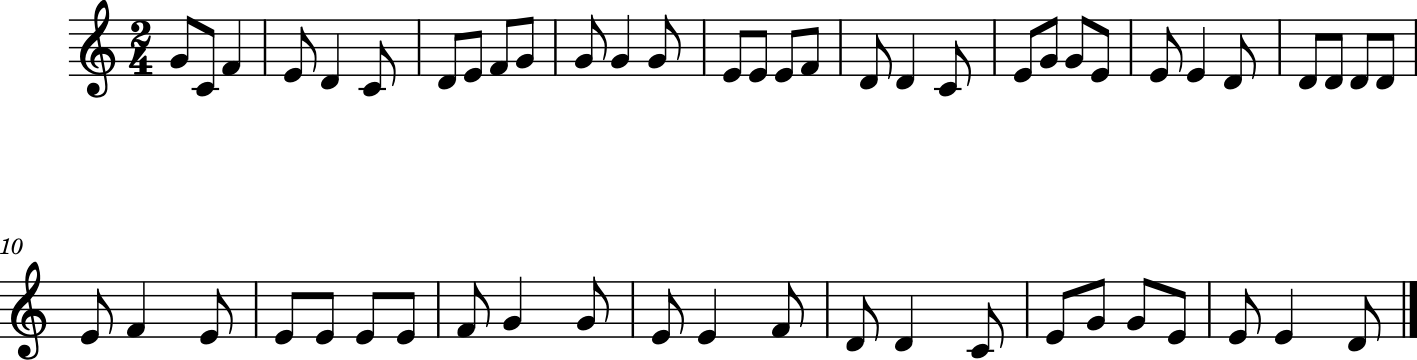

In [34]:
us=music21.environment.UserSettings()
us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"
m.show()

###  코드 사전 정의

In [6]:
note_seq

'g8e8e4f8d8d4c8d8e8f8g8g8g4g8e8e8e8f8d8d4c8e8g8g8e8e8e4d8d8d8d8d8e8f4e8e8e8e8e8f8g4g8e8e4f8d8d4c8e8g8g8e8e8e4'

In [7]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([seq])
encoded = t.texts_to_sequences([seq])[0]
print(encoded)
print(t.word_index)

[2, 1, 5, 4, 3, 6, 7, 3, 1, 4, 2, 2, 8, 2, 1, 1, 1, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5, 3, 3, 3, 3, 3, 1, 9, 1, 1, 1, 1, 1, 4, 8, 2, 1, 5, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5]
{'e8': 1, 'g8': 2, 'd8': 3, 'f8': 4, 'e4': 5, 'd4': 6, 'c8': 7, 'g4': 8, 'f4': 9}


In [8]:
code2idx = {'c4': 0, 'd4': 1, 'e4': 2, 'f4': 3, 'g4': 4, 'a4': 5, 'b4': 6,
            'c8': 7, 'd8': 8, 'e8': 9, 'f8': 10, 'g8': 11, 'a8': 12, 'b8': 13}

idx2code = {0: 'c4', 1: 'd4', 2: 'e4', 3: 'f4', 4: 'g4', 5: 'a4', 6: 'b4',
            7: 'c8', 8: 'd8', 9: 'e8', 10: 'f8', 11: 'g8', 12: 'a8', 13: 'b8'}

## 데이터셋 생성하기

### 데이터셋 생성 함수

In [9]:
code2idx['g8']

11

In [10]:
# seq를 학습시킬 데이터 셋으로 반환하는 함수
# seq = 음계가 담긴 list, window_size:독립변수의 갯수
def seq2dataset(seq, window_size):
    dataset = []
    
    for i in range(len(seq) - window_size):
        subset = seq[i: (i + window_size + 1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

In [11]:
print(seq[0:10])
print(seq2dataset(seq[0:10], 4))

['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8']
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]]


### 생성

In [12]:
n_steps = 4 # 4개씩 학습(독립변수 갯수)
n_inputs = 1
dataset = seq2dataset(seq=seq, window_size=n_steps)
print(dataset[:2])
print(dataset.shape)

[[11  9  2 10  8]
 [ 9  2 10  8  1]]
(50, 5)


### 입력(X)과 출력(Y) 변수로 분리하기

In [13]:
x_train = dataset[:, :-1]
y_train = dataset[:, -1]
print(dataset[0])
print(x_train[0], y_train[0])
print(x_train.shape, y_train.shape)

[11  9  2 10  8]
[11  9  2 10] 8
(50, 4) (50,)


In [14]:
# 정규화 시킬 때 나눌 값 : code2idx의 제일 큰 values값
max_idx_value = max(code2idx.values())
max_idx_value

13

### 입력값 정규화 시키기

In [15]:
x_train = x_train / float(max_idx_value)

### 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환

In [16]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_inputs))

### 라벨값에 대한 one-hot 인코딩 수행

In [17]:
y_train = utils.to_categorical(y_train)

In [18]:
one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is {0}".format(one_hot_vec_size))
print("After pre-processing")
print("x_train: {0}".format(x_train.shape))
print("y_train: {0}".format(y_train.shape))

one hot encoding vector size is 12
After pre-processing
x_train: (50, 4, 1)
y_train: (50, 12)


## 모델 구성하기

In [19]:
model = Sequential()
model.add(LSTM(
    units=128,
    kernel_initializer='glorot_normal',
    bias_initializer='zero',
    batch_input_shape=(1, n_steps, n_inputs), 
    stateful=True
))
model.add(Dense(
    units=one_hot_vec_size, 
    kernel_initializer='glorot_normal',
    bias_initializer='zero',    
    activation='softmax'
))

## 모델 학습과정 설정하기

In [20]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 모델 학습시키기

### 손실 이력 클래스 정의

In [21]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        if self.epoch % 100 == 0:
            print("epoch: {0} - loss: {1:8.6f}, accuracy : {2:8.6f}".\
                  format(self.epoch, logs.get('loss'), logs.get('accuracy')))
            
        self.epoch += 1

### 학습

In [22]:
num_epochs = 1500
history = LossHistory()  # 손실 이력 객체 생성

for epoch_idx in range(num_epochs + 1):
    model.fit(
        x=x_train,
        y=y_train,
        epochs=1,
        batch_size=1,
        verbose=0,
        shuffle=False,
        callbacks=[history]
    )
    if history.losses[-1] < 1e-5:
        print("epoch: {0} - loss: {1:8.6f}".format(epoch_idx, history.losses[-1]))
        model.reset_states()    
        break
    model.reset_states()

epoch: 0 - loss: 2.416600, accuracy : 0.300000
epoch: 100 - loss: 1.180034, accuracy : 0.520000
epoch: 200 - loss: 0.021510, accuracy : 1.000000
epoch: 300 - loss: 0.000346, accuracy : 1.000000
epoch: 400 - loss: 0.006573, accuracy : 1.000000
epoch: 500 - loss: 0.000255, accuracy : 1.000000
epoch: 600 - loss: 0.000018, accuracy : 1.000000
epoch: 700 - loss: 0.028440, accuracy : 1.000000
epoch: 800 - loss: 0.102638, accuracy : 1.000000
epoch: 900 - loss: 0.000476, accuracy : 1.000000
epoch: 1000 - loss: 0.000033, accuracy : 1.000000
epoch: 1046 - loss: 0.000010


In [23]:
print("{:.5f}".format(1e-5))

0.00001


## 학습과정 살펴보기

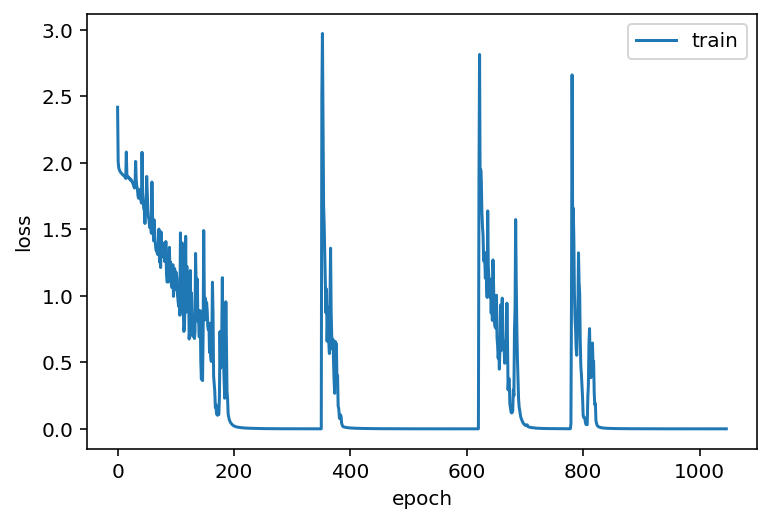

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## 모델 평가하기

In [25]:
scores = model.evaluate(x_train, y_train, batch_size=1)
print("{0}: {1}".format(model.metrics_names[1], scores[1]*100))
model.reset_states()

50/50 [==============================] - 1s 896us/step - loss: 9.9444e-06 - accuracy: 1.0000
accuracy: 100.0


## 모델 사용하기

### 한 스텝 예측

In [26]:
x_train[0]
temp = x_train[0].reshape(1,4,1)
temp

array([[[0.84615385],
        [0.69230769],
        [0.15384615],
        [0.76923077]]])

In [27]:
idx = np.argmax(model.predict(temp))
idx

8

In [28]:
idx2code[idx]

'd8'

### 곡 전체 예측

In [30]:
pred_count = 50 # 최대 예측 갯수
seq_in = ['g8', 'c8', 'f4', 'e8']
seq_out = seq_in
seq_in = [code2idx[note] / float(max_idx_value) for note in seq_in]  # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, n_steps, n_inputs))  # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()

print("full song prediction : ")

for note in seq_out:
    print(note, end=" ")

full song prediction : 
g8 c8 f4 e8 d4 c8 d8 e8 f8 g8 g8 g4 g8 e8 e8 e8 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 e8 f8 g4 g8 e8 e4 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 

In [31]:
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_08_installingMusicXML.html
import music21

note_seq = ""
for note in seq_out:
    note_seq += note + " "
    
conv_midi = music21.converter.subConverters.ConverterMidi()

m = music21.converter.parse("2/4 " + note_seq, format='tinyNotation')

m.show("midi")

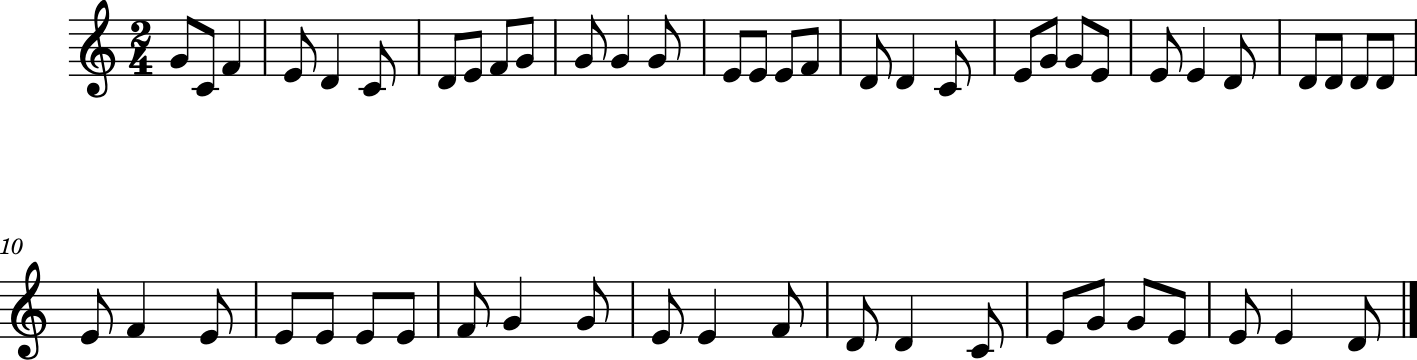

In [32]:
m.show()

In [33]:
m.write("midi", fp="./new_music.mid")

'./new_music.mid'